# HR Churn Analysis

# Import Libraries

In [0]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

plt.rcParams['figure.facecolor'] = 'w' # For Colab in dark mode
sns.set()
#current_palette = sns.color_palette("cubehelix")
#current_palette = sns.color_palette("Paired")
#sns.set_palette(current_palette)

# Specify the custom font to use

plt.rcParams["axes.labelweight"] = "bold"

# Save path for whatever needs to be output
save_path = ''

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import classification_report

from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier

In [0]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# EDA

In [0]:
path = ''

In [0]:
df = pd.read_csv(path, index_col=[0])

In [0]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [0]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


 Check for nulls

In [0]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

**OBSERVATIONS**: No null entries.

Text(0.5, 0, 'Satisfaction Level')

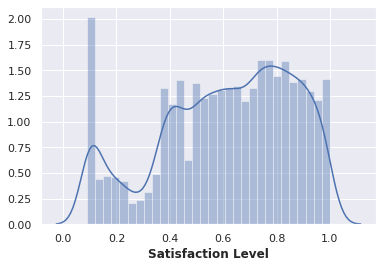

In [0]:
sns.distplot(df['satisfaction_level'])
plt.xlabel('Satisfaction Level')

**OBSERVATIONS**: A wide range of satisfaction from employees.

([<matplotlib.axis.XTick at 0x7f6b2889c128>,
 [Text(0, 0, 'No Churn'), Text(0, 0, 'Churn')])

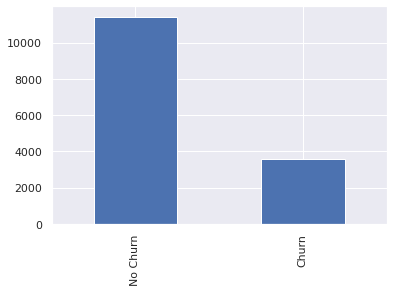

In [0]:
df['churn'].value_counts().plot(kind='bar')
plt.xticks((0,1),('No Churn', 'Churn'))

**OBSERVATIONS**: We can see an imbalance of target classes in this data set.